In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
import os
from textwrap import wrap

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add,Dropout,Embedding,LSTM,Bidirectional,Dense,Input,Concatenate,Reshape,concatenate
from tensorflow.keras.models import Sequential,Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping,ReduceLROnPlateau

In [38]:
img_path  = '/kaggle/input/flickr8k/Images'
df = pd.read_csv('/kaggle/input/flickr8k/captions.txt')

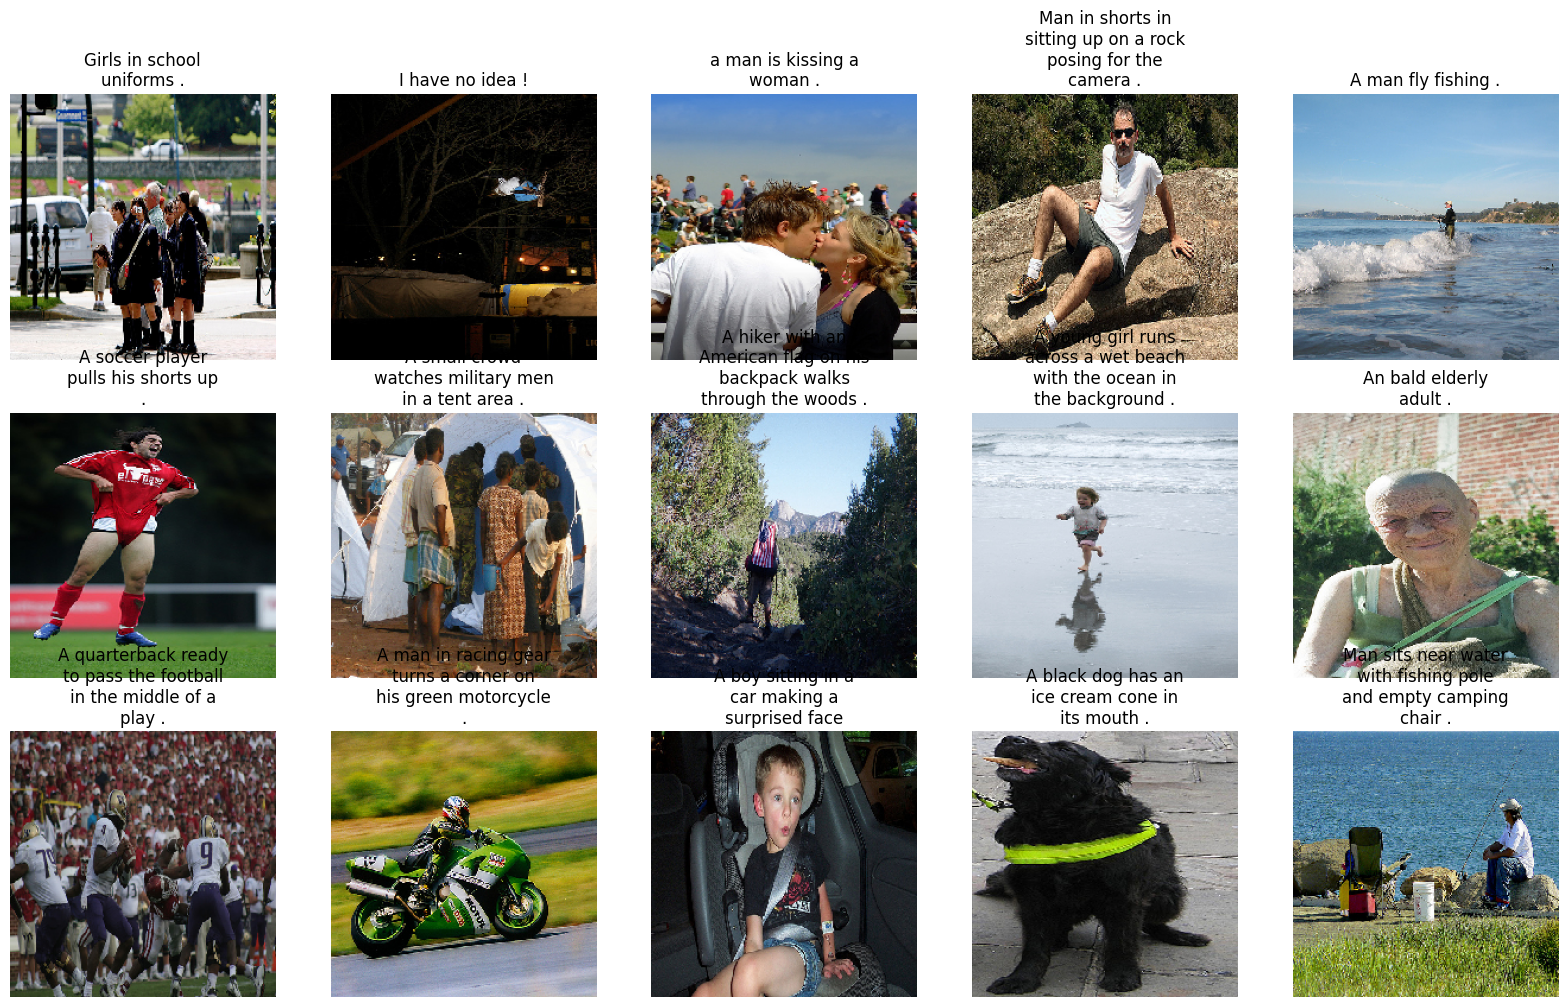

In [39]:
def read_img(path,img_size=224):
    img = load_img(path,target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img


def displayImage(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        image = read_img(f"/kaggle/input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i],20)))
        plt.axis('off')
        
displayImage(df.sample(15))
    

In [40]:
def text_preprocessing(df):
    df['caption'] = df['caption'].apply(lambda x:x.lower())
    df['caption'] = df['caption'].apply(lambda x:x.replace("[^A-Za-z]",""))
    df['caption'] = df['caption'].apply(lambda x:x.replace("\s+"," "))
    df['caption'] = df['caption'].apply(lambda x:" ".join([word for word in x.split() if len(word)>1]))
    df['caption'] = "<sos> " + df['caption'] + " <end>"
    

    
text_preprocessing(df)
caption = df['caption'].tolist()

In [41]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(caption)
vocab = len(tokenizer.word_index)+1
max_len = max([len(caption.split())for caption in caption])
max_len

34

In [42]:
images  =df['image'].unique().tolist()
len_img = len(images)

split_index = round(0.85*len_img)
train_img = images[:split_index]
test_img = images[split_index:]

train = df[df['image'].isin((train_img))]
test = df[df['image'].isin((test_img))]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [50]:
model = DenseNet201(weights='/kaggle/input/densenet201/tensorflow2/default/1/densenet201_weights_tf_dim_ordering_tf_kernels.h5', include_top=True)


fe = Model(inputs=model.input,outputs=model.layers[-2].output)

img_size=224
features ={}

for image in tqdm(df['image'].unique().tolist()):
    img = load_img(os.path.join(img_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img,verbose=0)
    features[image] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1765024554.863123     124 service.cc:148] XLA service 0x7b23a0003100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765024554.863907     124 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765024557.324614     124 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765024571.940027     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [15:47<00:00,  8.54it/s]


In [53]:
fe.save("feature_extractor_model.h5")

In [57]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab
        self.max_length = max_len
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=img_path,
                                      tokenizer=tokenizer,vocab_size=vocab,max_length=max_len,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=img_path,
                                      tokenizer=tokenizer,vocab_size=vocab,max_length=max_len,features=features)

In [58]:
train_generator[1]

((array([[1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         ...,
         [7.6072298e-05, 6.1783084e-04, 1.9857232e-03, ..., 5.4502711e-02,
          1.0848639e+00, 2.5176878e+00],
         [7.6072298e-05, 6.1783084e-04, 1.9857232e-03, ..., 5.4502711e-02,
          1.0848639e+00, 2.5176878e+00],
         [7.6072298e-05, 6.1783084e-04, 1.9857232e-03, ..., 5.4502711e-02,
          1.0848639e+00, 2.5176878e+00]], dtype=float32),
  array([[   0,    0,    0, ...,    0,    0,    2],
         [   0,    0,    0, ...,    0,    2,  184],
         [   0,    0,    0, ...,    2,  184, 1053],
         ...,
         [   0,    0,    0, ...,    4,  773,    3],
         [   0,    0,    0, ...,  773,    3,  258],

In [74]:
input1 =Input(shape=(1920,))
input2 =Input(shape=(max_len,))

img_features = Dense(256,activation='relu')(input1)
img_features_rs = Reshape((1,256),input_shape=(256,))(img_features)

sentence_features = Embedding(vocab,256,mask_zero=False)(input2)

merge = concatenate([img_features_rs,sentence_features],axis=1)
sentence_features=LSTM(256)(merge)

x = Dropout(0.5)(sentence_features)
x = add([x,img_features])

x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)

output=Dense(vocab,activation='softmax')(x)
caption_model = Model(inputs=[input1,input2],outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

model_name = "model.keras" 
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.2,min_lr=1e-8)

history = caption_model.fit(train_generator,epochs=50,validation_data=validation_generator,callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 5.6741
Epoch 1: val_loss improved from inf to 4.27634, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - loss: 5.6730 - val_loss: 4.2763 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 4.3259
Epoch 2: val_loss improved from 4.27634 to 3.96070, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 75s 140ms/step - loss: 4.3258 - val_loss: 3.9607 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 4.0167
Epoch 3: val_loss improved from 3.96070 to 3.81406, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - loss: 4.0167 - val_loss: 3.8141 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 3.8189
Epoch 4: val_loss improved from 3.81406 to 3.72082, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - loss: 3.8189 - val_loss: 3.7208 - learning_rate: 0.0010


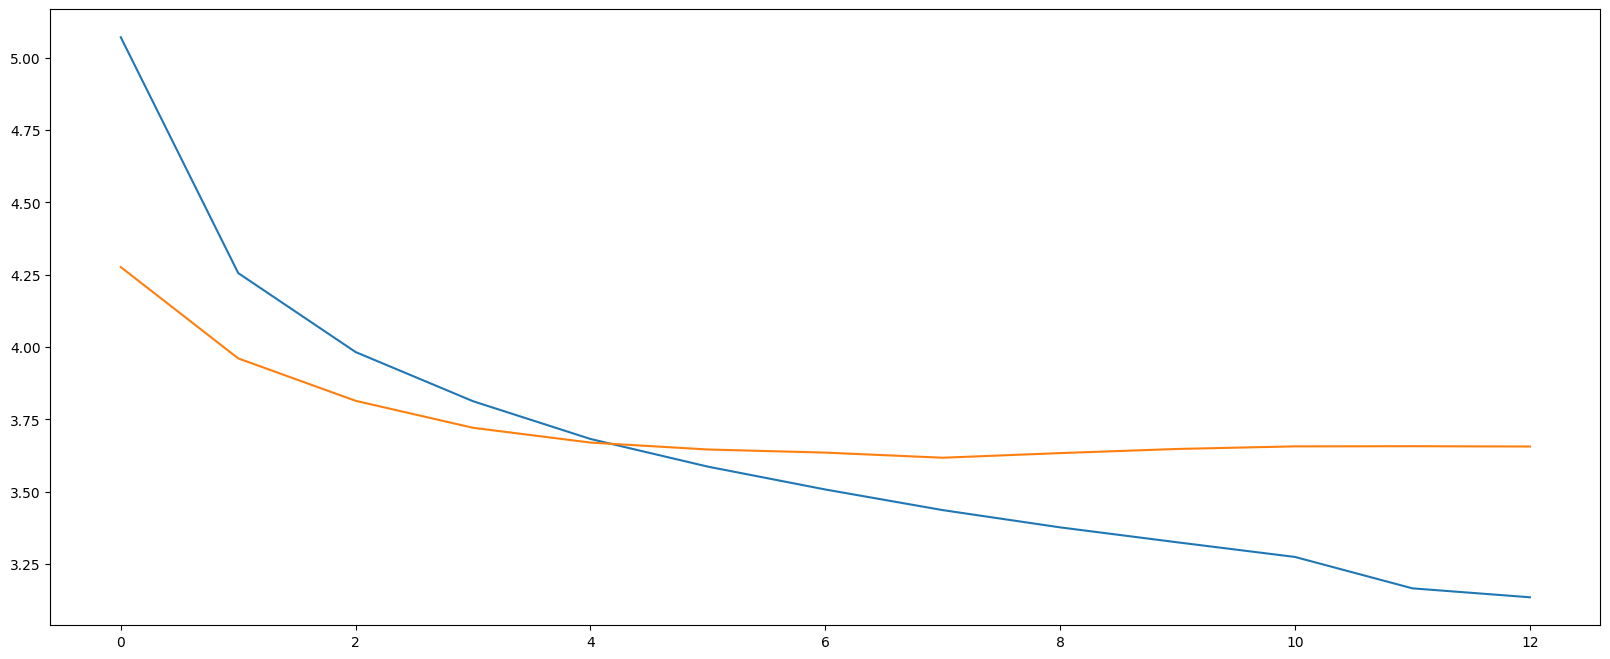

In [75]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])